# Deep Walk

- Adjacency matrix is essentially a list of one-hot encoding vectors for each neighbour of a given node.
- Takes graph as input and returns the latent representation as output. 

## Parallels with NLP
||Networks|NLP|
|---|--------|---|
|Vocabulary|Nodes|Words|
|Sentence|Random Walks|Sentence/Document|

**Note:** for a window length of $w$, we will see $2w + 1$ words at a time

## Skipgram
> Given sentence as `we iterate over all the vertices` and window length `w`. <br>
> For the word `over` predict `all`, `the`, `we` and `iterate`.

In [29]:
import numpy as np
import matplotlib.pyplot as plt
import heapq

In [35]:
class DeepWalk:
        def __init__(self, graph : "list[list[int]]", window_size : int, embedding_size : int, walks_per_vertex : int, walk_length : int) -> None:
                """
                Initialize the DeepWalk model. This directly from the paper https://arxiv.org/pdf/1403.6652.pdf.

                Parameters
                ----------
                graph : list[list[int]]
                        The adjacency list to be embedded. This is a list of lists, where each list is a vertex and its neighbors.
                window_size : int
                        The window size for the skipgram model.
                embedding_size : int
                        The size of the embedding. The final output matrix will be of size |V| x embedding_size.
                walks_per_vertex : int
                        The number of walks to perform per vertex.
                walk_length : int
                        The length of each walk.
                """
                self.g = graph
                self.w = window_size
                self.d = embedding_size
                self.gamma = walks_per_vertex
                self.epochs = self.gamma
                self.t = walk_length
                self.n = len(graph)
                self.word2id = {i : i for i in range(self.n)}
                self.id2word = {i : i for i in range(self.n)}

        def _huffman_encode(self) -> "dict[int, str]":
                """
                Huffman encode the graph for hierarchical softmax.
                """
                huffman_tree = dict()

                # Calculate the word frequencies in the graph
                word_frequencies = {}  # Initialize an empty dictionary to store word frequencies
                for vertex_neighbors in self.g:
                        for neighbor in vertex_neighbors:
                                if neighbor in word_frequencies:
                                        word_frequencies[neighbor] += 1
                                else:
                                        word_frequencies[neighbor] = 1

                # Construct a priority queue for Huffman tree construction
                priority_queue = [(-freq, int(word)) for word, freq in word_frequencies.items()]
                heapq.heapify(priority_queue)

                # Build the Huffman tree
                while len(priority_queue) > 1:
                        left, right = heapq.heappop(priority_queue), heapq.heappop(priority_queue)
                        merged_node = (left[0] + right[0], [left, right])
                        heapq.heappush(priority_queue, merged_node)

                # Assign binary codes to words in the Huffman tree
                def build_huffman_codes(node, code):
                        if isinstance(node[1], list):
                                build_huffman_codes(node[1][0], code + '0')
                                build_huffman_codes(node[1][1], code + '1')
                        else:
                                word = int(node[1])
                                huffman_tree[word] = code

                huffman_tree = {}  # Initialize an empty dictionary to store Huffman codes
                build_huffman_codes(priority_queue[0], '')  # Start building Huffman codes from the root node

                return huffman_tree


        def _random_walk(self, vertex : int) -> "list[int]":
                """
                Perform a random walk on the graph.

                Parameters
                ----------
                vertex : int
                        The vertex to start the random walk from.
                """
                walk = [vertex]
                for _ in range(self.t - 1):
                        neighbors = self.g[walk[-1]]
                        walk.append(np.random.choice(neighbors))
                return walk
        
        def _skipgram(self, u : int, v : int, learning_rate : float) -> None:
                """
                Perform the skipgram model.

                Parameters
                ----------
                u : int
                        The vertex to be embedded.
                v : int
                        The context vertex.
                learning_rate : float
                        The learning rate for the model.
                """
                # Get the embedding of the vertex
                u_embedding = self.embedding[u]

                # Get the embedding of the context vertex
                v_embedding = self.embedding[v]

                # Calculate the probability of the context vertex given the vertex
                # This is the sigmoid function
                prob = 1 / (1 + np.exp(-np.dot(u_embedding, v_embedding)))

                # Calculate the error
                error = prob - self.huffman_tree[v]

                # Update the embedding of the vertex
                self.embedding[u] = u_embedding - learning_rate * error * v_embedding

                # Update the embedding of the context vertex
                self.embedding[v] = v_embedding - learning_rate * error * u_embedding

        def train(self, learning_rate : float) -> "list[list[float]]":
                """
                Train the DeepWalk model.

                Parameters
                ----------
                learning_rate : float
                        The learning rate for the model.
                """
                
                # Initialize the embedding matrix.
                # We will use a uniform distribution to initialize the matrix.
                # The matrix will be of size |V| x d.
                # We will also normalize the matrix so that each row has unit norm.
                self.embedding = np.random.uniform(size=(self.n, self.d))
                self.embedding = self.embedding / np.linalg.norm(self.embedding, axis=1).reshape(-1, 1)

                # Huffman encoding the graph for hierarchical softmax.
                self.huffman_tree = self._huffman_encode()
                print(self.huffman_tree)
                
                # Train the model
                for epoch in range(1, self.epochs + 1):
                        for vertex in range(self.n):
                                # Perform the random walk
                                walk = self._random_walk(vertex)

                                # Perform the skipgram model
                                for i in range(self.t):
                                        for j in range(max(0, i - self.w), min(self.t, i + self.w + 1)):
                                                if i != j:
                                                        self._skipgram(walk[i], walk[j], learning_rate)

        

In [36]:
import networkx as nx

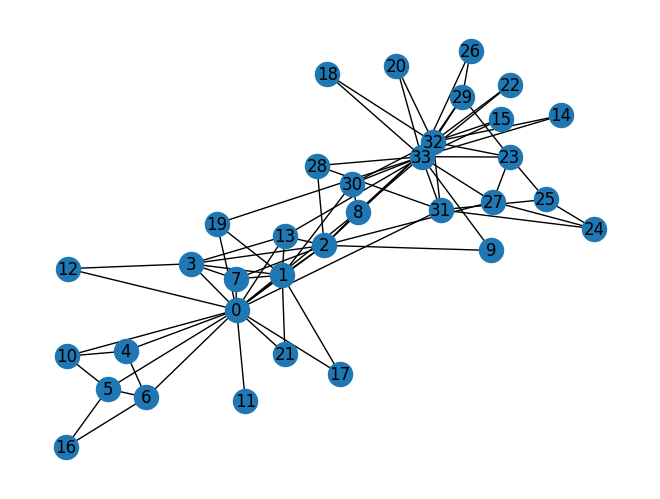

In [37]:
G = nx.karate_club_graph()
nx.draw(G, with_labels=True)

In [38]:
adjmat = nx.adjacency_matrix(G).todense()

dw = DeepWalk(adjmat, 2, 2, 10, 10)
dw.train(0.01)

print(dw.embedding)

{0: '0000000', 3: '0000001', 2: '000001', 4: '00001', 5: '0001', 1: '001', 6: '01', 7: '1'}


UFuncTypeError: ufunc 'subtract' did not contain a loop with signature matching types (dtype('float64'), dtype('<U7')) -> None